In [510]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import json

file_path = "results.csv" 
data = pd.read_csv(file_path)

data['layer_number'] = data['layer'].str.extract(r'layer_(\d+)').astype(int)  # Extract the number and convert to int
data = data.sort_values(by='layer_number').drop(columns=['layer_number']) 

In [512]:
def rotate_point(x, y, angle_degrees):
    # Convert angle to radians
    angle_radians = angle_degrees / 360 * 2 * math.pi
    
    # Apply rotation formulas
    x_new = x * math.cos(angle_radians) - y * math.sin(angle_radians)
    y_new = x * math.sin(angle_radians) + y * math.cos(angle_radians)
    
    return x_new, y_new

In [548]:
import numpy as np
import json

def apply_gaussian_kernel(data, width=2, sigma=1):
    """
    Applies a Gaussian kernel to the point cloud data in cylindrical coordinates.
    
    Parameters:
        data (dict): The input data containing layers of points in cylindrical coordinates.
        width (int): The width of the kernel (number of neighboring points to consider on each side).
        sigma (float): The standard deviation of the Gaussian kernel.
    
    Returns:
        list: A list of smoothed points in the format [x, y, z].
    """
    def calculate_distance(x):
        # Example polynomial function for calculating distance
        return -5.40274 * (x ** 3) + 28.4823 * (x ** 2) - 49.7115 * x + 31.3444

    def gaussian_weight(distance, sigma):
        """Calculate the Gaussian weight for a given distance."""
        return np.exp(-0.5 * (distance / sigma) ** 2)

    def rotate_point(x, y, angle):
        """Rotate a point (x, y) by a given angle in degrees."""
        radians = np.radians(angle)
        new_x = x * np.cos(radians) - y * np.sin(radians)
        new_y = x * np.sin(radians) + y * np.cos(radians)
        return new_x, new_y

    # Parse the data and organize it into layers
    layers = []
    for j, layer in enumerate(data['data']):
        json_data = json.loads(layer)
        if json_data['finished']['S'] == "true":
            break
        points = json_data['data']['S'].split(',')[:-1]
        z = float(json_data['height']['S'])
        layer_points = []

        invalid = False
        for i, reading in enumerate(points):
            if reading == '':
                continue

            voltage = int(reading) / 32767 * 4.096
            distance = calculate_distance(voltage)

            if distance > 8:
                invalid = True
                break
            x, y = rotate_point(6-distance, -1, -6)
            x, y = rotate_point(x, y, i * 360 / len(points))
            x, y = rotate_point(x, y, 6)
            layer_points.append([x * 8, y * 8, z])
        
        if not invalid:
            layers.append(layer_points)

    layers = layers[:-3]

    # Apply Gaussian smoothing
    smoothed_points = []
    num_layers = len(layers)

    for j, layer in enumerate(layers):
        num_points = len(layer)
        smoothed_layer = []

        for i, point in enumerate(layer):
            x, y, z = point
            weighted_sum = np.array([0.0, 0.0, 0.0])
            total_weight = 0.0

            # Iterate over neighboring points in cylindrical coordinates
            for dj in range(-width, width + 1):  # Neighboring layers
                for di in range(-width, width + 1):  # Neighboring points in the angular direction
                    neighbor_layer_index = (j + dj) % num_layers  # Wrap around vertically
                    neighbor_point_index = (i + di) % num_points  # Wrap around angularly

                    if neighbor_layer_index < 0 or neighbor_point_index < 0:
                        continue

                    neighbor_point = layers[neighbor_layer_index][neighbor_point_index]
                    dx = neighbor_point[0] - x
                    dy = neighbor_point[1] - y
                    dz = neighbor_point[2] - z

                    # Calculate the Euclidean distance
                    distance = np.sqrt(dx ** 2 + dy ** 2 + dz ** 2)

                    # Calculate the Gaussian weight
                    weight = gaussian_weight(distance, sigma)
                    weighted_sum += np.array(neighbor_point) * weight
                    total_weight += weight

            # Normalize the weighted sum to get the smoothed point
            smoothed_point = weighted_sum / total_weight if total_weight != 0 else point
            smoothed_layer.append(smoothed_point)

        smoothed_points.extend(smoothed_layer)

    return smoothed_points

In [550]:
points = apply_gaussian_kernel(data, width=5, sigma=1)

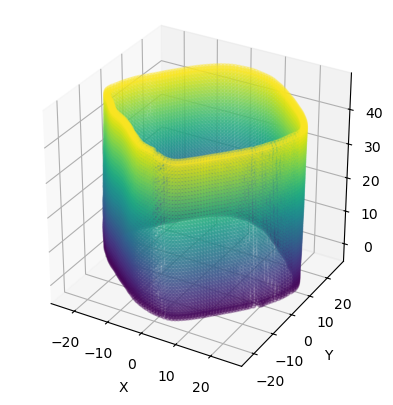

In [551]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Example: Assuming mapped_points is already defined
# Extract x, y, z coordinates
x = [point[0] for point in points]
y = [point[1] for point in points]
z = [point[2] for point in points]

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot the points
sc = ax.scatter(x, y, z, c=z, cmap='viridis', marker='o', alpha=0.3)  # Color by z for shading


# Set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Ensure axes are equally spaced
max_range = max(
    max(x) - min(x),  # Range of x
    max(y) - min(y),  # Range of y
    max(z) - min(z)   # Range of z
) / 2.0

# Calculate the midpoints of each axis
mid_x = (max(x) + min(x)) / 2.0
mid_y = (max(y) + min(y)) / 2.0
mid_z = (max(z) + min(z)) / 2.0

# Set the limits for each axis to ensure equal spacing
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

# Add a grid for better visualization
ax.grid(True)

# Set the aspect ratio to ensure equal spacing
ax.set_box_aspect([1, 1, 1])  # Equal aspect ratio for x, y, z axes

# Add some shading using trisurf (optional, for surface-like shading)
from scipy.spatial import Delaunay

# Perform a Delaunay triangulation on the points
tri = Delaunay(np.column_stack((x, y)))


# Show the plot
plt.show()

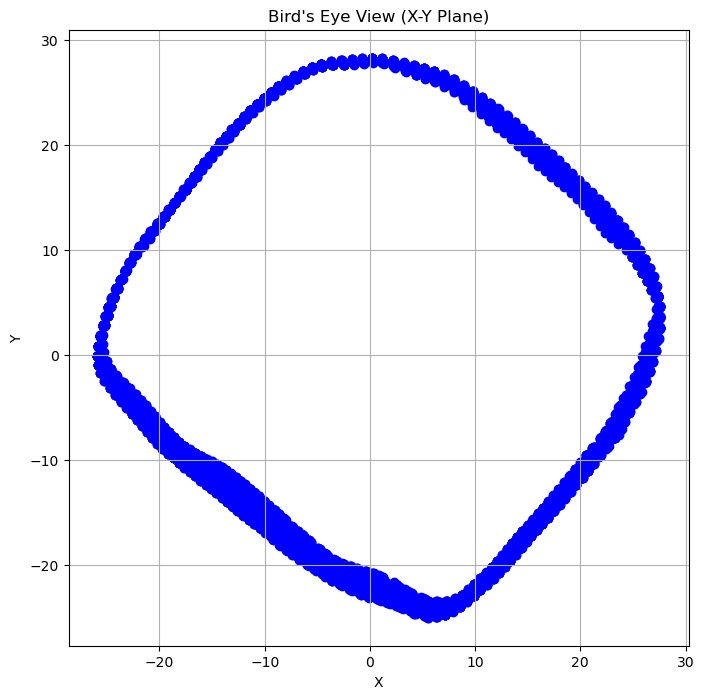

In [555]:
import matplotlib.pyplot as plt

# Example: Assuming x and y are already defined
plt.figure(figsize=(8, 8))
plt.scatter(x, y, c='blue', marker='o')

# Add labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title("Bird's Eye View (X-Y Plane)")

# Set equal spacing for x and y axes
plt.axis('equal')  # Ensures equal scaling for x and y axes

# Add grid for better visualization
plt.grid(True)

# Show the plot
plt.show()